## Installation

In [ ]:
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.6 MB/s eta 0:00:00


### Training a causal language model from scratch

We will then use the Trainer API and 🤗 Accelerate to train the model. Let’s get to it!

**Gathering the data**

In [ ]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(5000)),
        "valid": ds_valid.shuffle().select(range(8))
    }
)

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 8
    })
})

**Tokenize the data**

The first step will be to tokenize the data, so we can use it for training. Since our goal is to mainly autocomplete short function calls, we can keep the context size relatively small.
For now, let’s fix the context size at 128 tokens, as opposed to the 1,024 or 2,048 used in GPT-2 or GPT-3, respectively.

- Most documents contain many more than 128 tokens, so simply truncating the inputs to the maximum length would eliminate a large fraction of our dataset. Instead, we’ll use the return_overflowing_tokens option to tokenize the whole input and split it into several chunks

- We’ll also use the return_length option to return the length of each created chunk automatically. Often the last chunk will be smaller than the context size, and we’ll get rid of these pieces to avoid padding issues; we don’t really need them as we have plenty of data anyway.

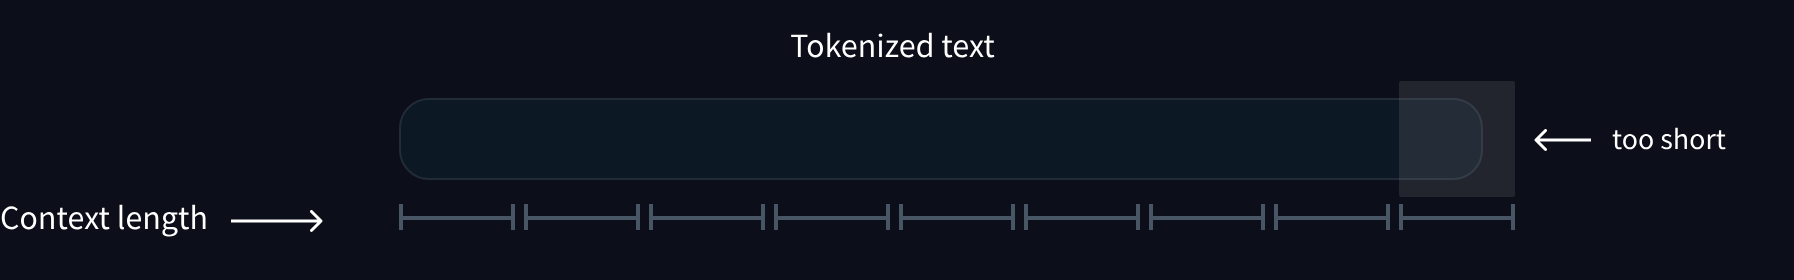



In [ ]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 61
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 109, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 9]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


- We can see that we get 34 segments in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 128 tokens (117 and 41, respectively).
- These represent just a small fraction of the total chunks that we have, so we can safely throw them away.
- we can create batches with more or fewer elements than the input batch

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 139420
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 100
    })
})

In [ ]:
tokenized_datasets['train']['input_ids'][1][:10]

[23368, 292, 13546, 8259, 292, 256, 7016, 675, 310, 9460]

✏️ Note! Getting rid of all the chunks that are smaller than the context size wasn’t a big issue here because we’re using small context windows. As you increase the context size (or if you have a corpus of short documents), the fraction of chunks that are thrown away will also grow.

✏️ Note! A more efficient way to prepare the data is to join all the tokenized samples in a batch with an eos_token_id token in between, and then perform the chunking on the concatenated sequences. As an exercise, modify the `tokenize()` function to make use of that approach. Note that you’ll want to set `truncation=False` and remove the other arguments from the tokenizer to get the full sequence of token IDs.

**Initializing a new model**

- We’ll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration.
- Make sure that the tokenizer size matches the model vocabulary size and pass the bos and eos (beginning and end of sequence) token IDs

In [ ]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
# downsize the model to save memory
# Issue with OOM due to validation
config.n_layer = 6
config.n_head = 6
# Initilize the model
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 81.7M parameters


In [ ]:
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 81.7M parameters


In [ ]:
model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50000, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50000, bias=False)
)

**Data Collator**

The `DataCollatorForLanguageModeling` collator, which is designed specifically for language modeling. Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don’t need to duplicate the `input_ids`.



In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


⚠️ Shifting the inputs and labels to align them happens inside the model, so the data collator just copies the inputs to create the labels.


- All that’s left to do is configure the training arguments and fire up the Trainer. We’ll use a cosine learning rate schedule with some warmup and an effective batch size of 256 (`per_device_train_batch_size` * `gradient_accumulation_steps`). Gradient accumulation is used when a single batch does not fit into memory, and incrementally builds up the gradient through several forward/backward passes.

**Metrics ( Evaluvation )**

Trainer supports adding evaluvation metrics to training arguments. The `Trainer` accepts a `compute_metrics` keyword argument that passes a function to compute metrics. One can specify the evaluation interval with `evaluation_strategy` in the TrainerArguments, and based on that, the model is evaluated accordingly, and the predictions and labels passed to `compute_metrics`.



In [ ]:
# !pip install -q evaluate

In [ ]:
import numpy as np
import evaluate

# Setup evaluation
# metric = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

import torch
import torch.nn.functional as F
import gc

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    # Predictions: (batch, seq_len)
    predictions = torch.argmax(logits, dim=-1)

    # Only evaluate non-masked tokens (labels != -100)
    mask = labels != -100

    # Compute accuracy
    correct = (predictions[mask] == labels[mask]).float().mean().item()

    # Compute perplexity
    log_probs = F.log_softmax(logits, dim=-1)
    # pick log-prob of the true label token
    true_token_log_probs = log_probs[labels != -100, labels[labels != -100]]
    cross_entropy = -true_token_log_probs.mean().item()
    perplexity = torch.exp(torch.tensor(cross_entropy)).item()

    gc.collect()  # Manually triggers garbage collection

    return {
        "next_token_accuracy": correct,
        "perplexity": perplexity
    }


**Training**

In [ ]:
model.loss_type, model.loss_function

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


(None,
 <function transformers.loss.loss_utils.ForCausalLMLoss(logits, labels, vocab_size: int, num_items_in_batch: Optional[torch.Tensor] = None, ignore_index: int = -100, shift_labels: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor>)

**Weights & Biases Setup**

In [ ]:
import os
os.environ["WANDB_PROJECT"] = "Pretrain Playground"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",

    per_device_train_batch_size=16, # Reduced for OOM
    per_device_eval_batch_size=1, # Reduced for OOM

    # Speed up training
    torch_compile=True,
    torch_compile_backend="inductor",
    torch_compile_mode="default",

    # Training mode
    do_train=True,

    eval_strategy="steps",
    eval_steps=100,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=1000,
    fp16=True,
    push_to_hub=False,
    eval_accumulation_steps=1,  # OOM
    remove_unused_columns=True, # OOM
    prediction_loss_only=False,    # required for metrics, OOM
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    optim="adamw_bnb_8bit",

    # Weights & biases
    report_to="wandb",
    run_name="GPT-Collab-Full-Param",
    logging_steps=100,
)

The speedups for torchdynamo mostly come with GPU Ampere or higher and which is not detected here.


In [ ]:
trainer = Trainer(
    model=model,
    processing_class=tokenizer, # tokenizer
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    compute_metrics=compute_metrics # for custom metrics
)

In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.
wandb: Currently logged in as: kailaspsudheer to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Next Token Accuracy,Perplexity
100,8.865400,6.852945,0.050859,2072.042480
200,6.274500,5.454971,0.010156,3161.200928
300,5.445600,4.917375,0.004375,4691.212891
400,5.055600,4.586475,0.004844,7686.991211
500,4.770300,4.386094,0.005469,9702.025391
600,4.519700,4.230679,0.004609,9241.938477
700,4.398700,4.092196,0.002266,9972.772461
800,4.191700,3.976827,0.003594,10321.116211
900,4.081400,3.881873,0.002891,12191.659180
1000,4.021200,3.792356,0.002188,12813.698242


wandb: Adding directory to artifact (codeparrot-ds/checkpoint-1000)... Done. 4.5s


In [ ]:
import wandb
wandb.finish()
# !wandb sync --id 93ti4t0l --project 'Pretrain Playground' --clean --sync-all

eval/loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/next_token_accuracy,█▃▅▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▁▂▂▂▁▁▂▂▂▁▂▂▂▂▂
eval/perplexity,▆▂▁▁▂▃▃▃▃▃▃▃▅▃▄▄▄▄▃▅▅▄▄▅▆▆▆▆▆▇▇▇▇███████
eval/runtime,▄▁▄▁▂▁▁▄▁▁▂▁▁▁▂▁▁▁▂▁█▂▂▁▁▁▂▁▁▂▁▂▁▁▁▁▂▁▁▁
eval/samples_per_second,▇▇▁▇█▇▇▆▇▇██▇█▇█▇▇▇▇▇▆██▇▆▇█▇▆█▆█▇▇▇▆▆▇█
eval/steps_per_second,▁▇▇█▇█████▇▇█████▇█▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇██▇
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇██
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train/grad_norm,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▂▂▃▃▃▃▃▄▅▅▅▆▆▆▇▇█████████▇▇▇▇▇▆▆▆▅▂▁▁▁▁
+1,...


**Custom Training Loop**


In [ ]:
import gc
gc.collect()  # Manually triggers garbage collection

261